<a href="https://colab.research.google.com/github/leesuyee/mesoscale-connectivity-tutorial/blob/main/mesoscale_connectivity_coding_activity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Set up environment**

Run the cell below to pip install the necessary packages. After install, restart the session and start at the next cell.

## **DO NOT RERUN THIS CELL**



In [2]:
!pip install s3fs lxml pandas brainglobe-atlasapi matplotlib numpy

  Using cached s3fs-2026.1.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached brainglobe_atlasapi-2.3.0-py3-none-any.whl.metadata (21 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.8/201.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 110.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2026.1.0 which is incompatible.
datasets 4.0.0 requires fsspec[h

In [14]:
!pip install numpy

In [3]:
# Setup Github repo and environment

import os
from pathlib import Path
import pandas as pd

# URL of your GitHub repo
repo_url = "https://github.com/leesuyee/mesoscale-connectivity-tutorial.git"
repo_dir = "/content/mesoscale-connectivity-tutorial"

# Clone the repo if it hasn't been cloned yet
if not os.path.exists(repo_dir):
    print(f"Cloning repository from {repo_url}...")
    !git clone {repo_url} {repo_dir}
else:
    print(f"Repository already exists at {repo_dir}")

# Change working directory to repo root
os.chdir(repo_dir)
print(f"Working directory set to: {os.getcwd()}")

# Verify metadata folder exists
metadata_dir = Path(repo_dir) / "metadata"
if not metadata_dir.exists():
    raise FileNotFoundError(
        f"Metadata folder not found in repo. Expected at {metadata_dir}"
    )
else:
    print(f"Metadata folder found at {metadata_dir}")

Cloning repository from https://github.com/leesuyee/mesoscale-connectivity-tutorial.git...
Cloning into '/content/mesoscale-connectivity-tutorial'...
remote: Enumerating objects: 2580, done.
remote: Counting objects: 100% (1711/1711), done.
remote: Compressing objects: 100% (1705/1705), done.
remote: Total 2580 (delta 5), reused 1708 (delta 5), pack-reused 869 (from 3)
Receiving objects: 100% (2580/2580), 61.26 MiB | 19.25 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Filtering content: 100% (1692/1692), 769.42 MiB | 22.51 MiB/s, done.
Working directory set to: /content/mesoscale-connectivity-tutorial
Metadata folder found at /content/mesoscale-connectivity-tutorial/metadata


In [4]:
from pathlib import Path
from brainglobe_atlasapi import BrainGlobeAtlas

# Path to the .brainglobe folder in your cloned repo
local_bg_dir = Path("/content/mesoscale-connectivity-tutorial/data/.brainglobe")

# Initialize the atlas using the local path
atlas = BrainGlobeAtlas(
    atlas_name="allen_mouse_25um",
    brainglobe_dir=local_bg_dir,
    check_latest=False  # disables network version check
)

print(atlas.reference.shape)

Output()

(528, 320, 456)


In [5]:
# Class to load SmartSPIM data asset from S3

import s3fs

class load_data:
    """
    Minimal Colab-compatible loader for SmartSPIM data (CCF coordinates and region counts) streamed directly from S3

    Parameters
    ----------
    mouse_ID : str | int
        Mouse ID (e.g. 689305)

        bucket : str
        S3 bucket name (e.g. "s3://aind-open-data")

        anon : bool
        Whether to use anonymous credentials (e.g. True)

        prefer_stitched : bool
        Whether to prefer stitched data (e.g. True)

    Attributes
    ----------
    rootDir : str
        Resolved S3 path to the selected SmartSPIM dataset.

    quantPaths : dict[str, str]
        Mapping from imaging channel (e.g., ``"488"``) to the
        corresponding ``cell_count_by_region.csv`` file path.

    ccfCellsPaths : dict[str, str]
        Mapping from imaging channel to the corresponding
        ``transformed_cells.xml`` file path containing CCF
        coordinates.

    channels : list[str]
        Sorted list of available imaging channels discovered
        for the dataset.

    Methods
   ----------
   resolve_paths()
        Method to get path to whole brain volume data

    getCellsCCFdf(ch: list[str])
        Retrieves and formats CCF transformed coordinates of segmented cells into a DataFrame

    getcellcounts(ch: list[str])
        Imports the cell_counts_by_region.csv

    """

    def __init__(
        self,
        mouse_ID: str | int,
        bucket: str = "s3://aind-open-data",
        anon: bool = True,
        prefer_stitched: bool = True,
    ):
        self.mouse_ID = str(mouse_ID)
        self.bucket = bucket
        self.fs = s3fs.S3FileSystem(anon=anon)
        self.prefer_stitched = prefer_stitched

        self._resolve_paths()

    # ------------------------------------------------------------------
    # Path resolution
    # ------------------------------------------------------------------
    def _resolve_paths(self):
      """
      Method to get path to whole brain volume data
      """
      roots = self.fs.ls(self.bucket)
      matches = [r for r in roots if self.mouse_ID in r]

      if not matches:
          raise FileNotFoundError(f"No datasets found for mouse_ID {self.mouse_ID}")

      if self.prefer_stitched:
          stitched = [r for r in matches if "stitched" in r.lower()]
          if len(stitched) == 1:
              self.rootDir = stitched[0]
          elif len(stitched) > 1:
              raise ValueError(f"Multiple stitched datasets found: {stitched}")
          else:
              self.rootDir = matches[0]
      else:
          self.rootDir = matches[0]

      quant_dir = f"{self.rootDir}/image_cell_quantification"
      if not self.fs.exists(quant_dir):
          raise FileNotFoundError("image_cell_quantification directory not found")

      quant_paths = self.fs.glob(f"{quant_dir}/Ex*")

      self.quantPaths = {
          Path(p).name.split("_")[1]: f"{p}/cell_count_by_region.csv"
          for p in quant_paths
      }
      self.ccfCellsPaths = {
          Path(p).name.split("_")[1]: f"{p}/transformed_cells.xml"
          for p in quant_paths
      }

      self.channels = sorted(self.quantPaths.keys())

    # ------------------------------------------------------------------
    # Cell coordinates in CCF
    # ------------------------------------------------------------------
    def getCellsCCFdf(self, ch: list[str]):
        """
        Retrieves and formats CCF transformed coordinates of segmented cells into a DataFrame

        Parameters
        ----------
        ch : list[str]
            List of imaging channels to retrieve coordinates from (e.g., ["488", "561"])

        Returns
        -------
        dfs : pd.DataFrame
            DataFrame cwhere each row is a cell and each column is a coordinate:
            AP (anterior-posterior), DV(dorsal-ventral), ML(medial-lateral),
            with an additional "channel column indicating the channel of origin
        """
        ccfDim = [528, 320, 456]
        dfs = []

        for channel in ch:
            if channel not in self.ccfCellsPaths:
                raise KeyError(f"Channel {channel} not found")

            with self.fs.open(self.ccfCellsPaths[channel], "rb") as f:
                df = pd.read_xml(
                    f,
                    xpath="//CellCounter_Marker_File//Marker_Data//Marker_Type//Marker",
                )

            # export data in XYZ order and rename columns to AP, DV, ML
            df = (
                df[["MarkerX", "MarkerY", "MarkerZ"]]
                .rename(
                    columns={
                        "MarkerX": "AP",
                        "MarkerY": "DV",
                        "MarkerZ": "ML",
                    }
                )
                .assign(channel=channel)
            )
            # Clip coordinates within specified dimensions
            df["AP"] = df["AP"].clip(0, ccfDim[0] - 1)
            df["DV"] = df["DV"].clip(0, ccfDim[1] - 1)
            df["ML"] = df["ML"].clip(0, ccfDim[2] - 1)

            dfs.append(df)

        return pd.concat(dfs, ignore_index=True)

    # ------------------------------------------------------------------
    # Cell counts by region
    # ------------------------------------------------------------------
    def getcellcounts(self, ch: list[str]):
        """
        Imports the cell_counts_by_region.csv (quantifiction of detected cells in brain regions) as a DataFrame

        Parameters
        ----------
        ch : list[str]
            List of imaging channels to retrieve coordinates from (e.g., ["488", "561"]

        Returns
        -------
        dfs : pd.DataFrame
            DataFrame where each row is a brain region cell count in a given channel
        """
        required_columns = [
            "ID", "Acronym", "Name", "Struct_Info", "Struct_area_um3",
            "Left", "Right", "Total",
            "Left_Density", "Right_Density", "Total_Density",
        ]

        # Initialize an empty list to hold DataFrames
        cell_counts_list = []

        for channel in ch:
            if channel not in self.quantPaths:
                raise KeyError(f"Channel {channel} not found")

            # Load csv
            with self.fs.open(self.quantPaths[channel], "rb") as f:
                df = pd.read_csv(f)

                # Check if all required columns are present
                if set(required_columns).issubset(df.columns):
                  # Truncate the DataFrame to specific columns
                  cell_counts = df[required_columns]
                  # Add a new column indicating the channel
                  cell_counts = cell_counts.assign(channel=channel)
                  # Append to list
                  cell_counts_list.append(cell_counts)

                # Throw error if missing columns
                if not set(required_columns).issubset(df.columns):
                    raise ValueError(f"Missing required columns in {channel}")

            # Concatenate list into a single DataFrame
            if cell_counts_list:
              cell_counts_df = pd.concat(cell_counts_list, ignore_index=True)
            else:
            # return empty DataFrame if no data is found
              cell_counts_df = pd.DataFrame(columns = required_columns + ["channel"])

        return cell_counts_df

In [6]:
# Load a data asset
mouse_ID = "689238"
data = load_data(mouse_ID)
channels = data.channels

ccf_df = data.getCellsCCFdf(channels)
cell_counts_df = data.getcellcounts(channels)

In [7]:
ccf_df

,AP,DV,ML,channel
0,217,27,193,445
1,220,27,191,445
2,218,27,197,445
3,264,35,108,445
4,252,30,143,445
...,...,...,...,...
460598,306,267,370,561
460599,322,272,345,561
460600,311,275,360,561
460601,308,259,376,561


In [8]:
cell_counts_df

,ID,Acronym,Name,Struct_Info,Struct_area_um3,Left,Right,Total,Left_Density,Right_Density,Total_Density,channel
0,997,root,root,mid,5.113271e+11,31285,146963,178248,1.223678e-07,5.748296e-07,3.485987e-07,445
1,8,grey,Basic cell groups and regions,hemi,2.312776e+11,30906,145553,176459,1.336316e-07,6.293434e-07,3.814875e-07,445
2,567,CH,Cerebrum,hemi,1.414069e+11,30548,140365,170913,2.160290e-07,9.926318e-07,6.043304e-07,445
3,688,CTX,Cerebral cortex,hemi,1.137573e+11,30425,139934,170359,2.674553e-07,1.230110e-06,7.487826e-07,445
4,695,CTXpl,Cortical plate,hemi,1.093212e+11,30226,137780,168006,2.764880e-07,1.260323e-06,7.684055e-07,445
...,...,...,...,...,...,...,...,...,...,...,...,...
2509,129,V3,third ventricle,mid,1.139386e+09,11,203,214,1.930865e-08,3.563323e-07,1.878205e-07,561
2510,140,AQ,cerebral aqueduct,mid,4.506497e+08,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,561
2511,145,V4,fourth ventricle,mid,1.372785e+09,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,561
2512,153,V4r,lateral recess,hemi,3.813698e+08,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,561


In [9]:
# Get metadata CSV
csv_path = metadata_dir / "metadata_filtered.csv"
metadata_df = pd.read_csv(csv_path)
metadata_df.head()

,Unnamed: 0,name,subject_id,genotype,sex,virus,titer,volume,age_days,days_to_perfusion,qc_tissue,ng_link,channel,qc_channel,ng_channel,ccf_ap,ccf_ml,ccf_dv,inj_structure,inj_parent
0,5,SmartSPIM_679519_2023-08-15_11-43-09_stitched_...,679519,Ai224(TICL-NLS-EGFP-ICF-NLS-dT)-hyg/wt,Male,AAVrg-Syn-Flpo,1.020000e+14,100.0,53,31,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,561,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,115,275,114,FRP6a,FRP
1,6,SmartSPIM_689237_2023-08-30_19-04-37_stitched_...,689237,wt/wt,Female,AAVrg-Syn-H2B-Turquoise,2.960000e+14,50.0,52,21,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,445,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,139,244,96,ACAd5,ACAd
2,7,SmartSPIM_689237_2023-08-30_19-04-37_stitched_...,689237,wt/wt,Female,AAVrg-Syn-H2B-tdTomato,5.100000e+13,50.0,52,21,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,561,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,140,295,86,MOs5,MOs
3,8,SmartSPIM_689238_2023-08-31_01-56-52_stitched_...,689238,wt/wt,Female,AAVrg-Syn-H2B-Turquoise,2.960000e+14,50.0,52,28,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,445,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,126,259,92,MOs5,MOs
4,9,SmartSPIM_689238_2023-08-31_01-56-52_stitched_...,689238,wt/wt,Female,AAVrg-Syn-H2B-tdTomato,5.100000e+13,50.0,52,28,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,561,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,122,237,138,ILA5,ILA


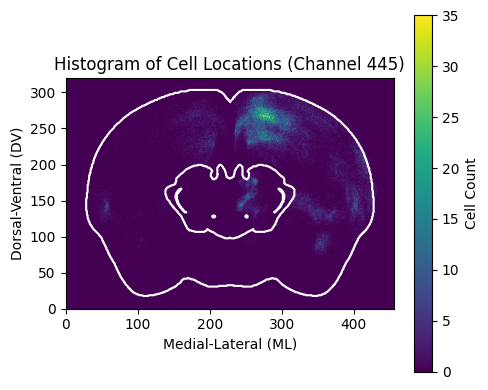

In [15]:
import matplotlib.pyplot as plt
import numpy as np
ch = '445' # select a channel
plane = 250 # anterior-posterior slice to plot
window = 100 # slice window bounds
roiList = ["root", "TH"] # brain structures to plot

# set figure parameters
fig, ax = plt.subplots(figsize=(5, 4))

cellLocs = ccf_df[ccf_df.channel == ch]
# generate the histogram of cell coordinates
planeLocs = cellLocs.loc[(cellLocs['AP'] >= plane - window) & (cellLocs['AP'] <= plane + window), :] # filter cellLocs to coordinates within AP slice bounds

# calculate bins for histogram
xbins = np.arange(0, atlas.get_structure_mask("root").shape[2], 1)
ybins = np.arange(0, atlas.get_structure_mask("root").shape[1], 1)

# create histogram of ML, DV coordinates
hist, xedges, yedges = np.histogram2d(
    planeLocs[planeLocs['channel'] == ch]["ML"],
    planeLocs[planeLocs['channel'] == ch]["DV"],
    bins=(xbins, ybins))

# overlay the heatmap
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
heatmap = ax.imshow(
    hist.T,  # transpose because imshow expects (rows, cols)
    extent=extent,
    origin="upper",
    cmap="viridis",
    alpha=1)

# generate contour outlines for brain structures
for roi in roiList:
    roi_mask = atlas.get_structure_mask(roi) # creates a binary array the size of the brain, mask out brain structures of interest
    ax.contour(roi_mask[plane, :, :],
        levels=[0.5],
        colors="white",
        linewidths=1.5,
        origin="upper") # plotting features for structure outline

# add colorbar and labels
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label("Cell Count")
ax.set_title(f"Histogram of Cell Locations (Channel {ch})")
ax.set_xlabel("Medial-Lateral (ML)")
ax.set_ylabel("Dorsal-Ventral (DV)")

plt.tight_layout()
plt.show()